In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, despine
from spatial_maps.fields import find_peaks, calculate_field_centers, separate_fields_by_laplace
from spike_statistics.core import permutation_resampling

import speed_cells.speed as spd
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

14:38:14 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "longitudinal-comparisons-speed"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

# Load cell statistics and shuffling quantiles

In [4]:
statistics_action = actions['calculate-statistics']
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')
statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics = pd.merge(session_units, statistics_results, how='left')
statistics.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,burst_event_ratio,bursty_spike_ratio,gridness,border_score,information_rate,information_specificity,head_mean_ang,head_mean_vec_len,spacing,orientation
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.398230,0.678064,-0.466923,0.029328,1.009215,0.317256,5.438033,0.040874,0.628784,20.224859
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.138014,0.263173,-0.666792,0.308146,0.192524,0.033447,1.951740,0.017289,0.789388,27.897271
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.373986,0.659259,-0.572566,0.143252,4.745836,0.393704,4.439721,0.124731,0.555402,28.810794
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.087413,0.179245,-0.437492,0.268948,0.157394,0.073553,6.215195,0.101911,0.492250,9.462322
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,0.248771,0.463596,-0.085938,0.218744,0.519153,0.032683,1.531481,0.053810,0.559905,0.000000


In [5]:
statistics['unit_day'] = statistics.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

## stim response

In [6]:
stim_response_action = actions['stimulus-response']
stim_response_results = pd.read_csv(stim_response_action.data_path('results'))
stim_response_results = stim_response_results.drop('unit_id', axis=1)

In [7]:
statistics = pd.merge(statistics, stim_response_results, how='left')

In [8]:
print('N cells:',statistics.shape[0])

N cells: 1284


In [9]:
shuffling = actions['shuffling']
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
quantiles_95.head()

,border_score,gridness,head_mean_ang,head_mean_vec_len,information_rate,speed_score,action,channel_group,unit_name
0,0.348023,0.275109,3.012689,0.086792,0.707197,0.149071,1833-010719-1,0.0,127.0
1,0.362380,0.166475,3.133138,0.037271,0.482486,0.132212,1833-010719-1,0.0,161.0
2,0.367498,0.266865,5.586395,0.182843,0.271188,0.062821,1833-010719-1,0.0,191.0
3,0.331942,0.312155,5.955767,0.090786,0.354018,0.052009,1833-010719-1,0.0,223.0
4,0.325842,0.180495,5.262721,0.103584,0.210427,0.094041,1833-010719-1,0.0,225.0


In [10]:
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

data['specificity'] = np.log10(data['in_field_mean_rate'] / data['out_field_mean_rate'])

data.head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,p_e_peak,t_i_peak,p_i_peak,border_score_threshold,gridness_threshold,head_mean_ang_threshold,head_mean_vec_len_threshold,information_rate_threshold,speed_score_threshold,specificity
0,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.332548,0.229073,6.029431,0.205362,1.115825,0.066736,0.451741
1,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.354830,0.089333,6.120055,0.073566,0.223237,0.052594,0.098517
2,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.264610,-0.121081,5.759406,0.150827,4.964984,0.027120,0.400770
3,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.344280,0.215829,6.033364,0.110495,0.239996,0.054074,0.269461
4,1849-060319-3,True,1849,NaN,False,True,3,NaN,False,baseline ii,...,NaN,NaN,NaN,0.342799,0.218967,5.768170,0.054762,0.524990,0.144702,0.133410


## waveform

In [11]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)
waveform_results = waveform_results.drop('unit_id', axis=1)

data = data.merge(waveform_results, how='left')
data.bs = data.bs.astype(bool)

# Statistics about all cell-sessions

In [12]:
data.groupby('stimulated').count()['action']

stimulated
False    624
True     660
Name: action, dtype: int64

# Find interneurons

In [13]:
data.loc[data.eval('t_i_peak == t_i_peak and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak != t_i_peak and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

In [14]:
# make baseline for inhibited vs not inhibited
data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

# Find all cells with gridness above threshold

In [15]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


## select neurons that have been characterized as a grid cell on the same day

In [16]:
once_a_gridcell = statistics[statistics.unit_day.isin(sessions_above_threshold.unit_day.values)]

In [17]:
print("Number of gridcells", once_a_gridcell.unit_idnum.nunique())
print("Number of gridcell recordings", len(once_a_gridcell))
print("Number of animals", len(once_a_gridcell.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 231
Number of animals 4


In [18]:
data.loc[:,'gridcell'] = np.nan
data['gridcell'] = data.isin(once_a_gridcell)

# divide into stim not stim

In [19]:
data.ns_inhibited.sum()

109

In [20]:
query_baseline_i = 'baseline and Hz11'
query_stimulated_11 = 'stimulated and frequency==11 and stim_location=="ms"'

query_baseline_ii = 'baseline and Hz30'
query_stimulated_30 = 'stimulated and frequency==30 and stim_location=="ms"'

print("Number of gridcells in baseline i sessions", 
      len(data.query('gridcell and ' + f'{query_baseline_i}')))
print("Number of gridcells in stimulated 11Hz ms sessions", 
      len(data.query('gridcell and ' + f'{query_stimulated_11}')))

print("Number of gridcells in baseline ii sessions", 
      len(data.query('gridcell and ' + f'{query_baseline_ii}')))
print("Number of gridcells in stimulated 30Hz ms sessions", 
      len(data.query('gridcell and ' + f'{query_stimulated_30}')))
print()
print("Number of NSi in baseline i sessions", 
      len(data.query('ns_inhibited and ' + f'{query_baseline_i}')))
print("Number of NSi in stimulated 11Hz ms sessions", 
      len(data.query('ns_inhibited and ' + f'{query_stimulated_11}')))

print("Number of NSi in baseline ii sessions", 
      len(data.query('ns_inhibited and ' + f'{query_baseline_ii}')))
print("Number of NSi in stimulated 30Hz ms sessions", 
      len(data.query('ns_inhibited and ' + f'{query_stimulated_30}')))

Number of gridcells in baseline i sessions 66
Number of gridcells in stimulated 11Hz ms sessions 61
Number of gridcells in baseline ii sessions 56
Number of gridcells in stimulated 30Hz ms sessions 40

Number of NSi in baseline i sessions 17
Number of NSi in stimulated 11Hz ms sessions 31
Number of NSi in baseline ii sessions 21
Number of NSi in stimulated 30Hz ms sessions 36


# Plotting

In [21]:
max_speed = .5 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size = 0.02
smoothing_low = 0.03
smoothing_high = 0.06

speed_binsize = 0.02

stim_mask = True
# baseline_duration = 600
baseline_duration = None

In [22]:
data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, 
    stim_mask=stim_mask, baseline_duration=baseline_duration
)

In [38]:
def compute_mask(search, t1, t2, z1, z2, z3):
    idxs = []
    idx = np.searchsorted(search, [t1 + z1, t1 + z2], side='right')
    idxs.extend(np.arange(idx[0], idx[1]).tolist())

    idx = np.searchsorted(search, [t1 + z3, t2], side='right')
    idxs.extend(np.arange(idx[0], idx[1]).tolist())
    return idxs

    
def load_speed(action_id, channel_id, unit_name, z1, z2, z3, split=False, stim_action=None):
    x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])

    spike_times = data_loader.spike_train(action_id, channel_id, unit_name)
    spike_times = spike_times[(spike_times > min(t)) & (spike_times < max(t))]
    
    stim_action = stim_action if stim_action is not None else action_id
    stim_times = data_loader.stim_times(stim_action)
    
    if stim_times is not None:
        idxs = []
        stim_times = np.array(stim_times)
        for t1, t2 in zip(stim_times, stim_times[1:]):
            idx = compute_mask(np.array(t), t1, t2, z1, z2, z3)
            idxs.extend(idx)
            
        idxs = np.sort(np.unique(idxs))
        mask = ~np.in1d(np.arange(len(t)), idxs)
    else:
        mask = np.zeros_like(t).astype(bool)
    
    if split:
        t_split = t[-1] / 2
        mask_speed = t < t_split
        speed1 = speed[mask_speed]
        speed2 = speed[~mask_speed]
        t1 = t[mask_speed]
        t2 = t[~mask_speed]
        mask1 = mask[mask_speed]
        mask2 = mask[~mask_speed]
        
        spike_mask = spike_times < t_split
        spike_times1 = spike_times[spike_mask]
        spike_times2 = spike_times[~spike_mask]
        
        return speed1, speed2, t1, t2, spike_times1, spike_times2, mask1, mask2
    
    return speed, t, spike_times, mask

In [45]:
z1, zg2, zi2, z3 = 0, 5e-3, 3e-3, 15e-3
gridcell_id_map = {}
gridcell_speed = [[], [], [], [], []]
gridcell_data = data.query('gridcell')

nsi_id_map = {}
nsi_speed = [[], [], [], [], []]
nsi_data = data.query('ns_inhibited')


n_iter = gridcell_data.unit_id.unique().shape[0] + nsi_data.unit_id.unique().shape[0]
pbar = tqdm(total=n_iter)

for nid, unit_sessions in gridcell_data.groupby('unit_id'):
    base_i = unit_sessions.query("baseline and Hz11")
    base_ii = unit_sessions.query("baseline and Hz30")
    stim_i = unit_sessions.query("frequency==11")
    stim_ii = unit_sessions.query("frequency==30")
    dfs = [(base_i, base_i), (base_i, base_ii), (base_i, stim_i), (base_ii, stim_ii), (base_i, stim_ii)]
    sample = [False, False, True, True, True]
    for i, pair in enumerate(dfs):
        same_frame = pair[0].equals(pair[1])
        for (_, row_1), (_, row_2) in zip(pair[0].iterrows(), pair[1].iterrows()):
            if same_frame:
                assert row_1.equals(row_2)
                speed1, speed2, t1, t2, spike_times1, spike_times2, mask1, mask2 = load_speed(
                    row_1['action'], row_1['channel_group'], row_1['unit_name'], 
                    z1, zg2, z3, split=True)
            else:
                assert not row_1.equals(row_2)
                stim_action = row_2['action'] if sample[i] else None
                speed1, t1, spike_times1, mask1 = load_speed(
                    row_1['action'], row_1['channel_group'], row_1['unit_name'], 
                    z1, zg2, z3, split=False, stim_action=stim_action)
                speed2, t2, spike_times2, mask2 = load_speed(
                    row_2['action'], row_2['channel_group'], row_2['unit_name'], 
                    z1, zg2, z3, split=False)

            speed_score1 = spd.speed_correlation(
                speed1, t1, spike_times1, return_data=False, mask=mask1)
            speed_score2 = spd.speed_correlation(
                speed2, t2, spike_times2, return_data=False, mask=mask2)
            
            gridcell_speed[i].append((speed_score1, speed_score2))

            assert row_1.unit_id == row_2.unit_id
            uid = row_2.unit_id
            idnum = row_1.unit_idnum
            gridcell_id_map[uid] = idnum
    pbar.update()

for nid, unit_sessions in nsi_data.groupby('unit_id'):
    base_i = unit_sessions.query("baseline and Hz11")
    base_ii = unit_sessions.query("baseline and Hz30")
    stim_i = unit_sessions.query("frequency==11")
    stim_ii = unit_sessions.query("frequency==30")
    dfs = [(base_i, base_i), (base_i, base_ii), (base_i, stim_i), (base_ii, stim_ii), (base_i, stim_ii)]
    sample = [False, False, True, True, True]
    for i, pair in enumerate(dfs):
        same_frame = pair[0].equals(pair[1])
        for (_, row_1), (_, row_2) in zip(pair[0].iterrows(), pair[1].iterrows()):
            if same_frame:
                assert row_1.equals(row_2)
                speed1, speed2, t1, t2, spike_times1, spike_times2, mask1, mask2 = load_speed(
                    row_1['action'], row_1['channel_group'], row_1['unit_name'], 
                    z1, zi2, z3, split=True)
            else:
                assert not row_1.equals(row_2)
                stim_action = row_2['action'] if sample[i] else None
                speed1, t1, spike_times1, mask1 = load_speed(
                    row_1['action'], row_1['channel_group'], row_1['unit_name'], 
                    z1, zi2, z3, split=False, stim_action=stim_action)
                speed2, t2, spike_times2, mask2 = load_speed(
                    row_2['action'], row_2['channel_group'], row_2['unit_name'], 
                    z1, zi2, z3, split=False)
            
            speed_score1 = spd.speed_correlation(
                speed1, t1, spike_times1, return_data=False, mask=mask1)
            speed_score2 = spd.speed_correlation(
                speed2, t2, spike_times2, return_data=False, mask=mask2)
            
            nsi_speed[i].append((speed_score1, speed_score2))

            assert row_1.unit_id == row_2.unit_id
            uid = row_2.unit_id
            idnum = row_1.unit_idnum
            nsi_id_map[uid] = idnum
    pbar.update()

pbar.close()

In [52]:
def session_id(row):
    if row.baseline and row.i:
        n = 0
    elif row.stimulated and row.i:
        n = 1
    elif row.baseline and row.ii:
        n = 2
    elif row.stimulated and row.ii:
        n = 3
    else:
        raise ValueError('what')
    return n
        
data['session_id'] = data.apply(session_id, axis=1)

In [95]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (8, 2), 
    'figure.dpi': 150
})

colors = ['#1b9e77','#d95f02','#7570b3', '#e7298a']

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


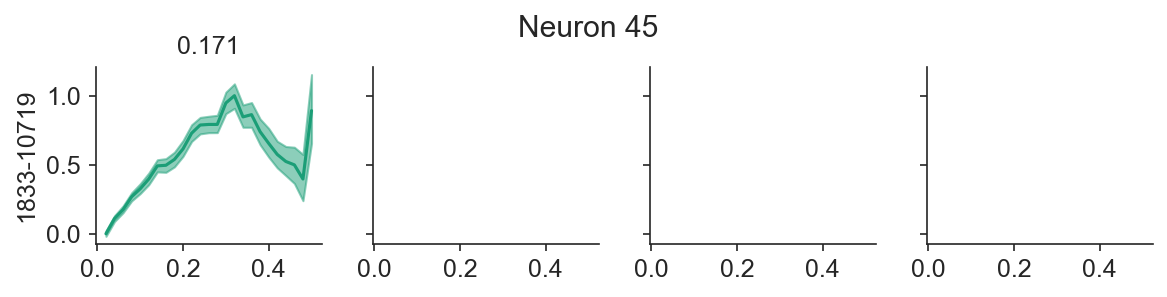

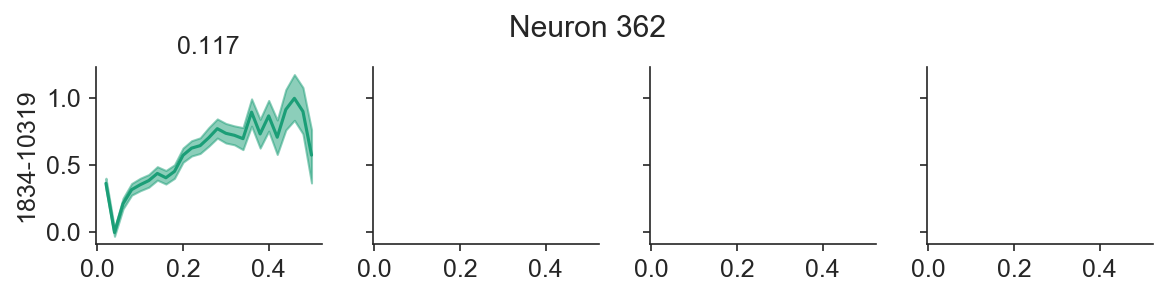

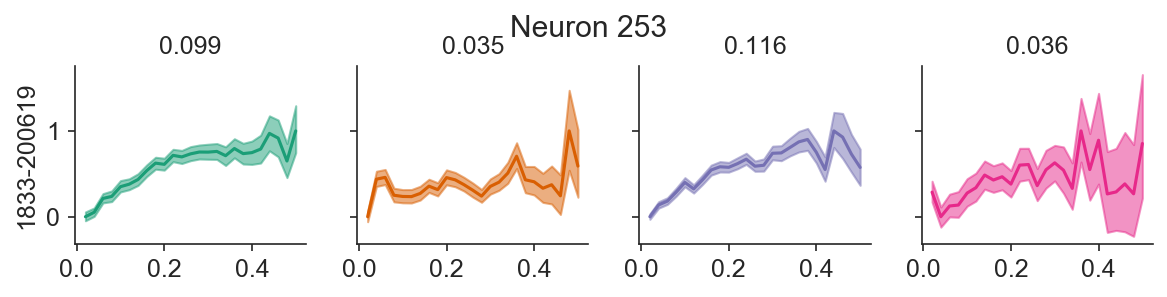

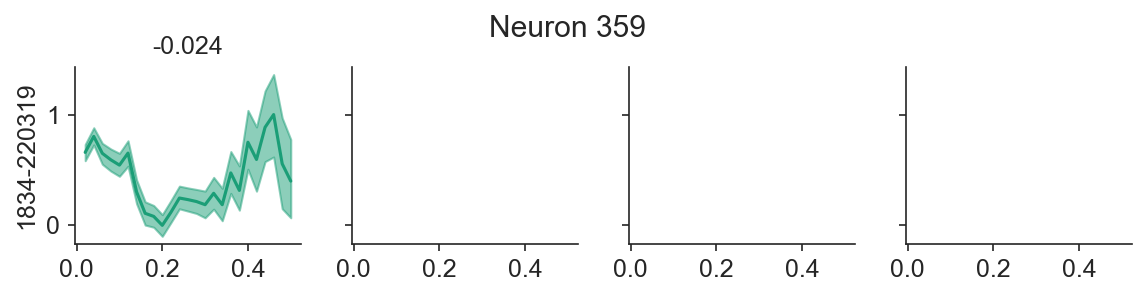

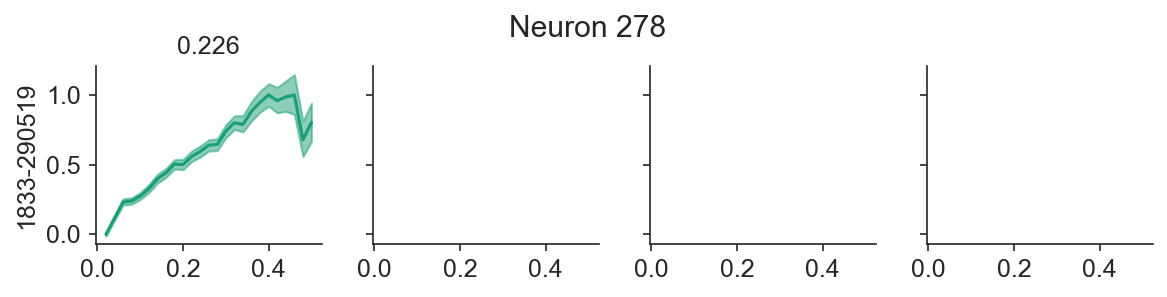

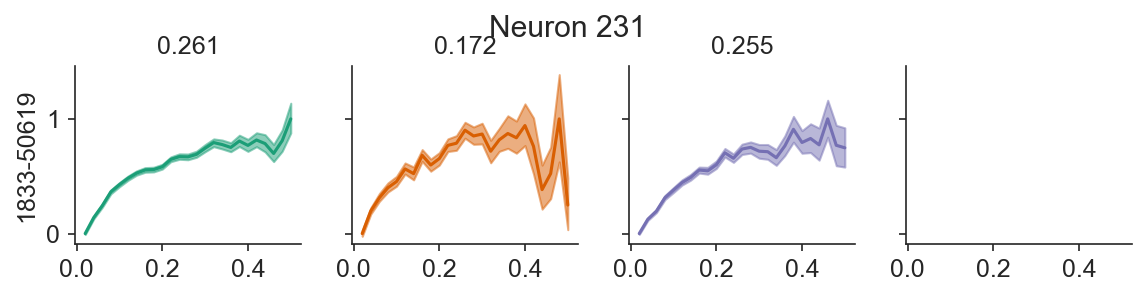

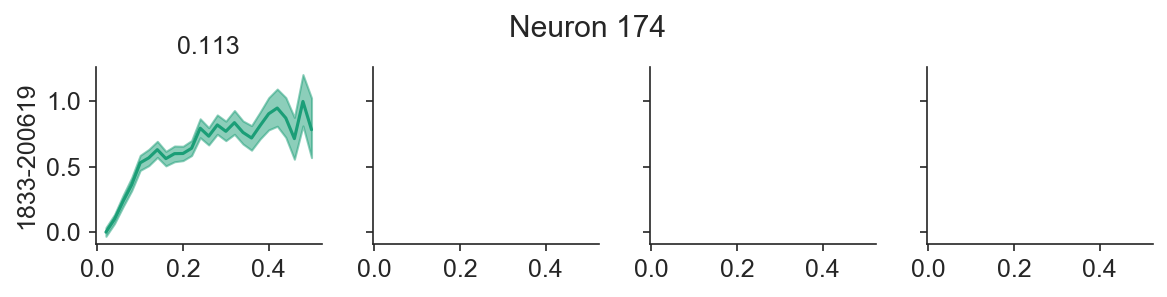

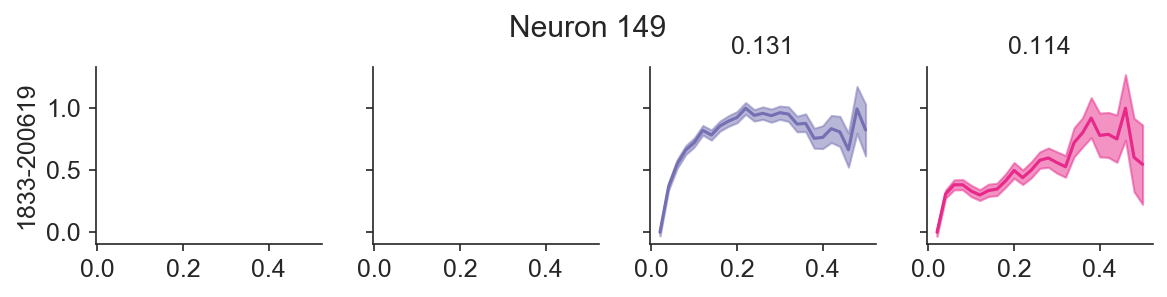

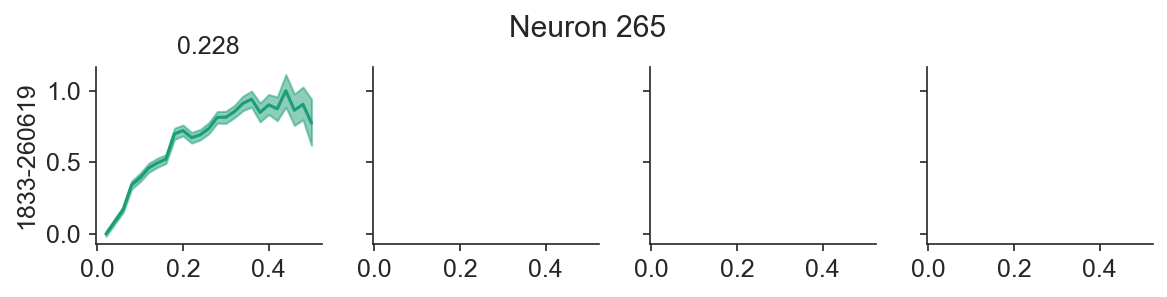

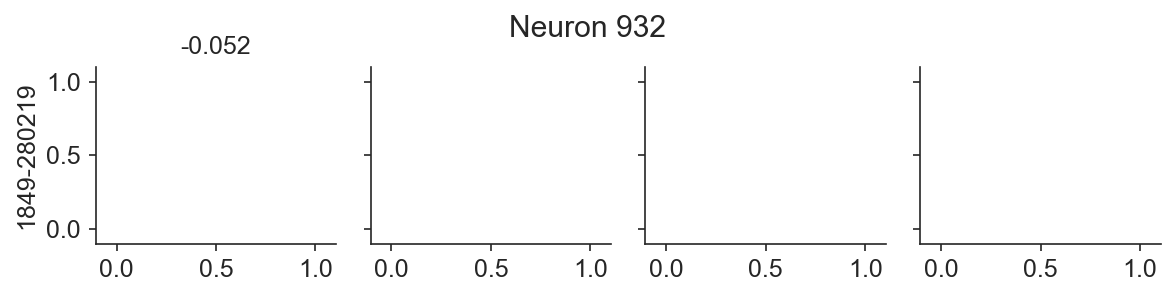

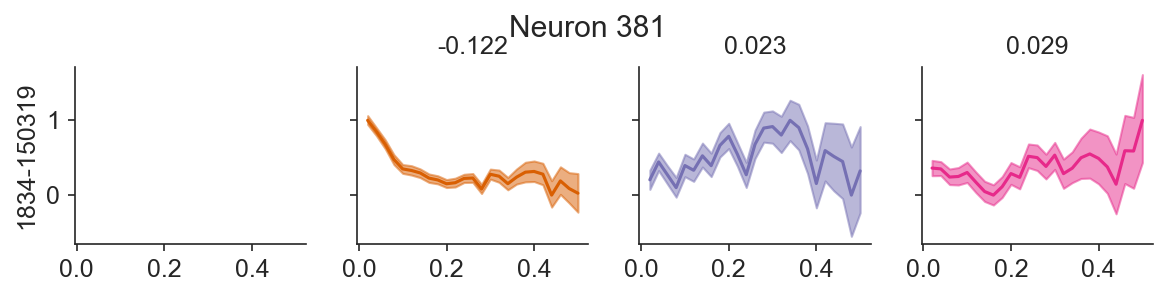

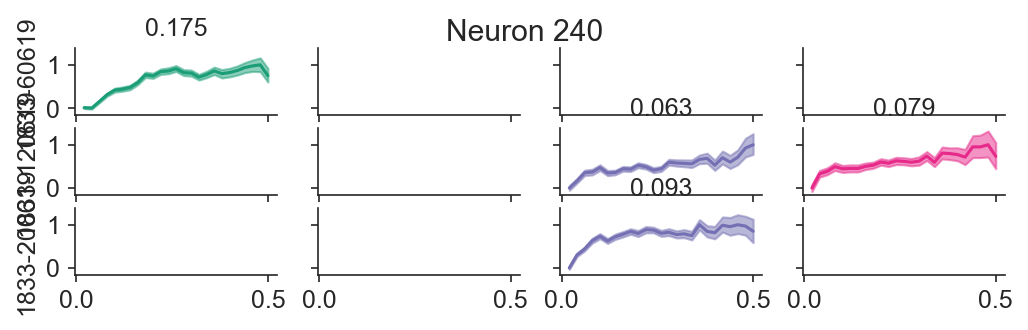

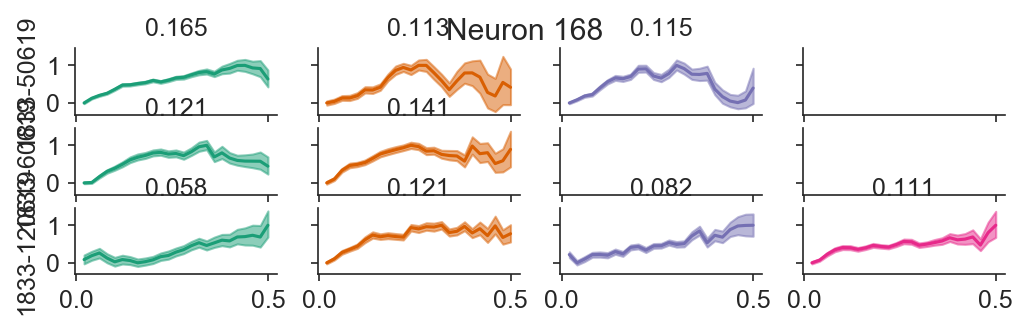

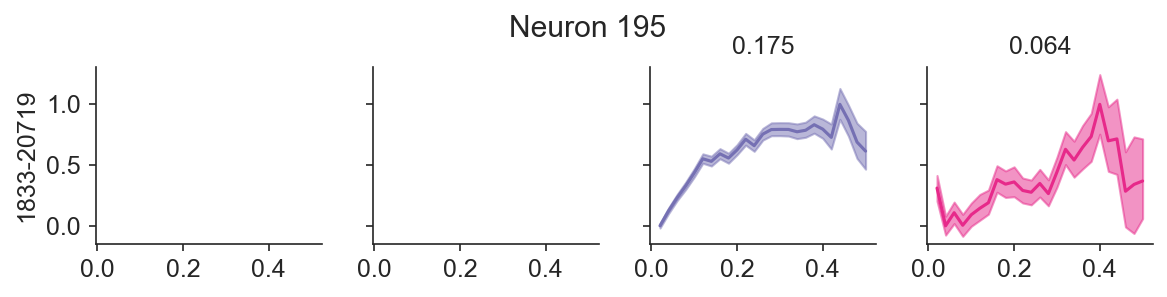

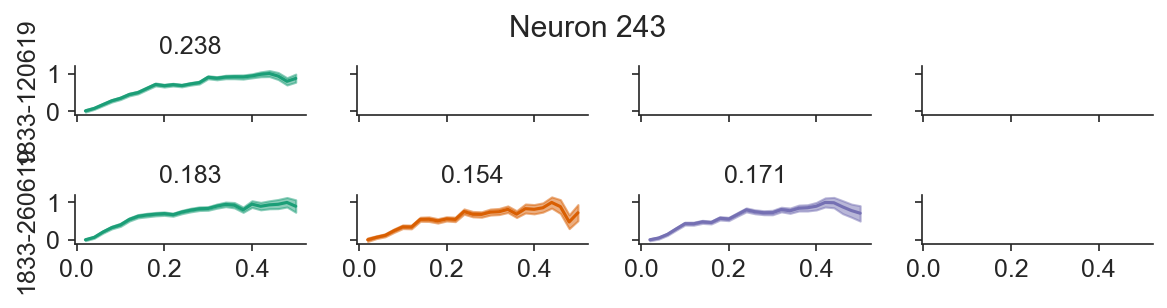

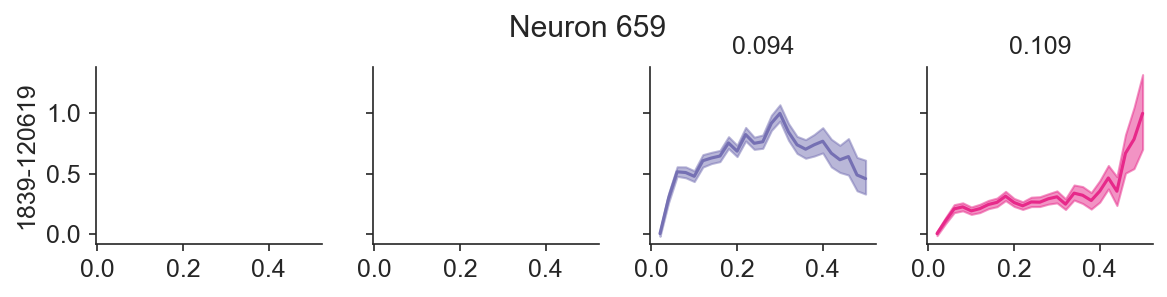

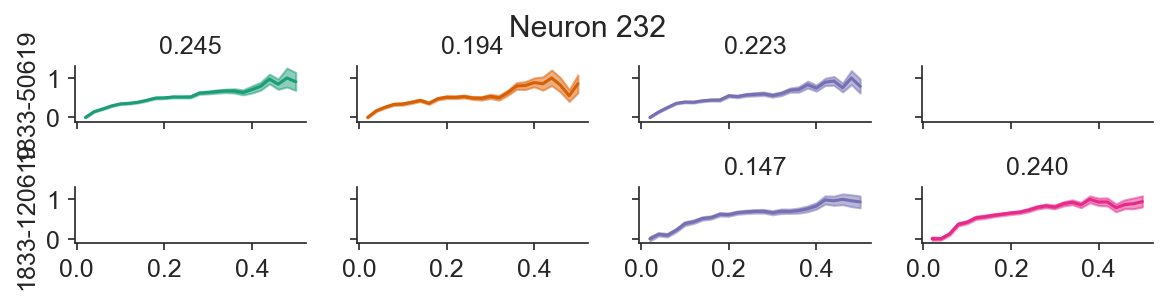

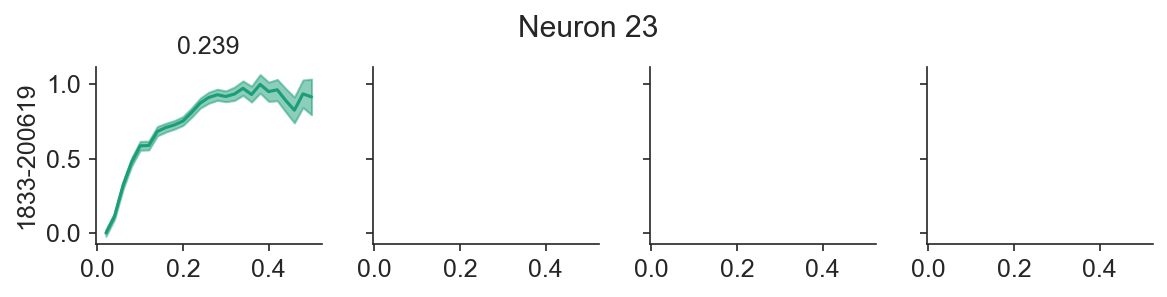

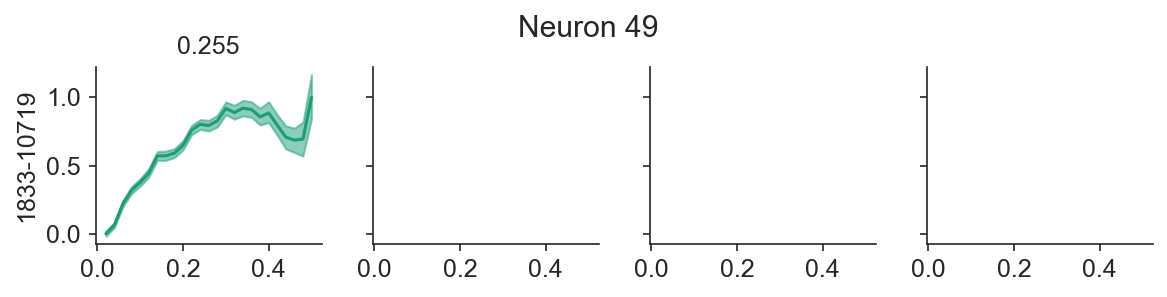

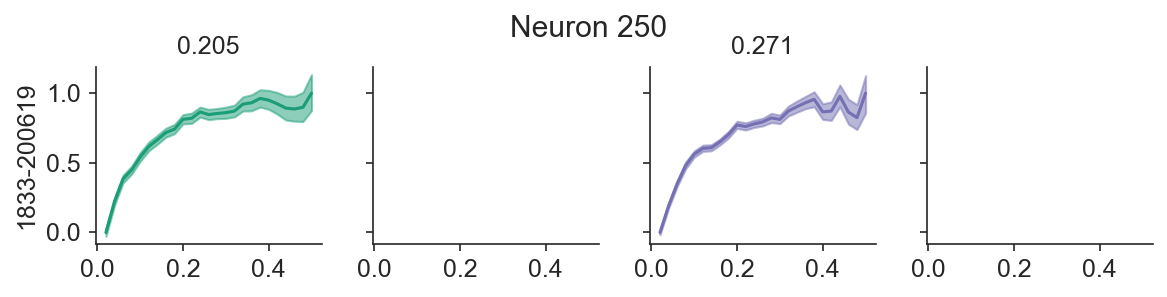

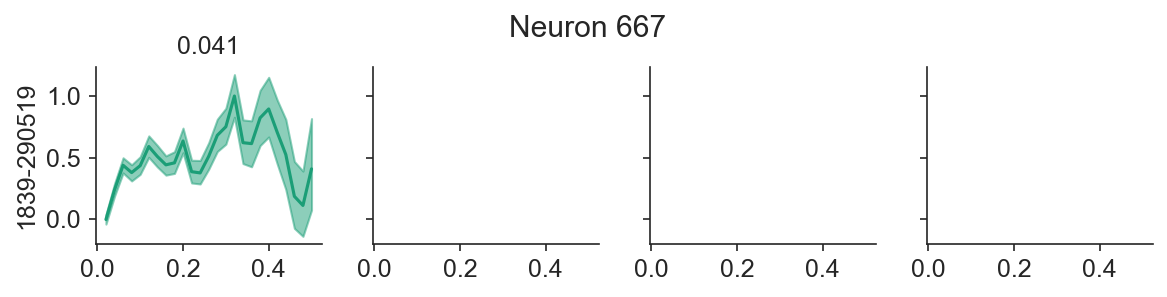

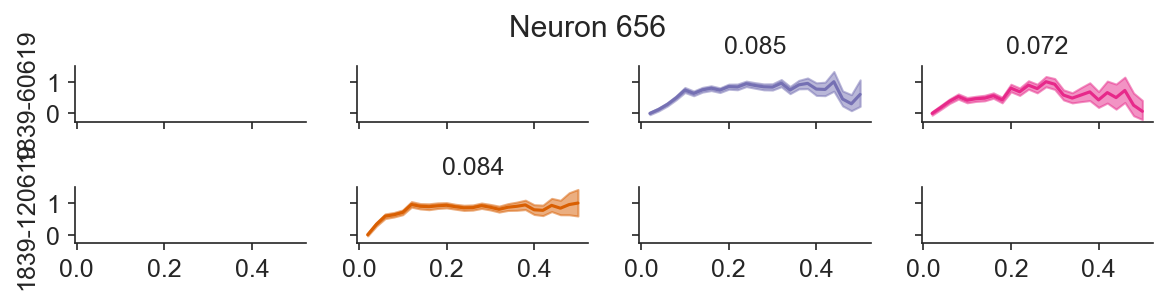

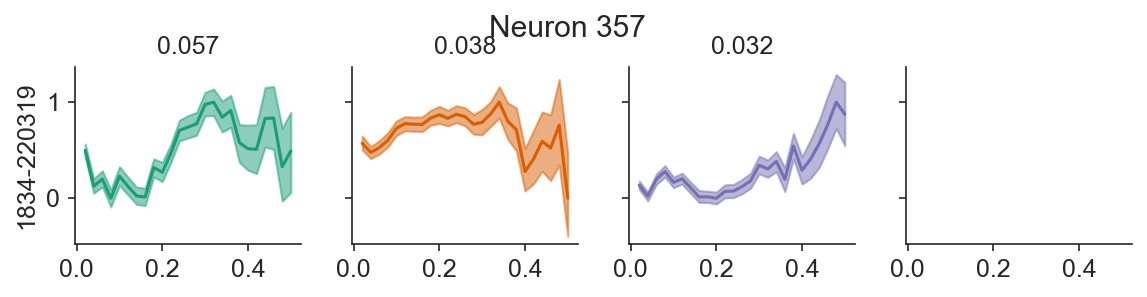

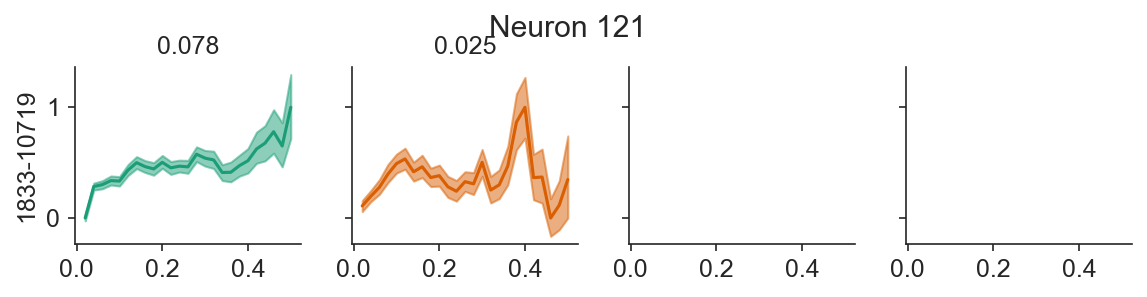

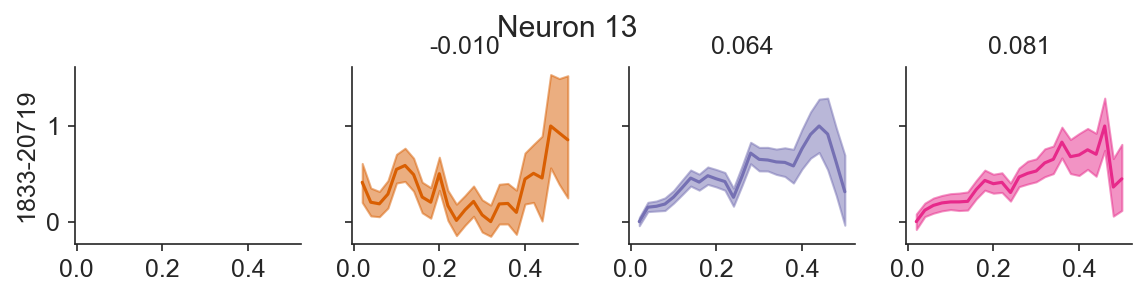

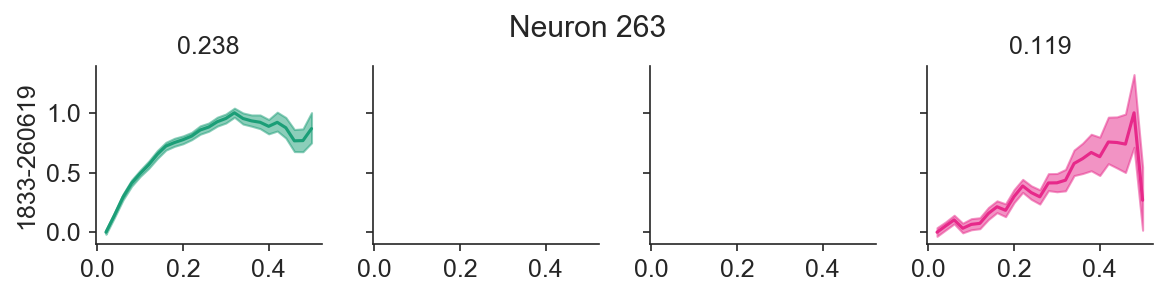

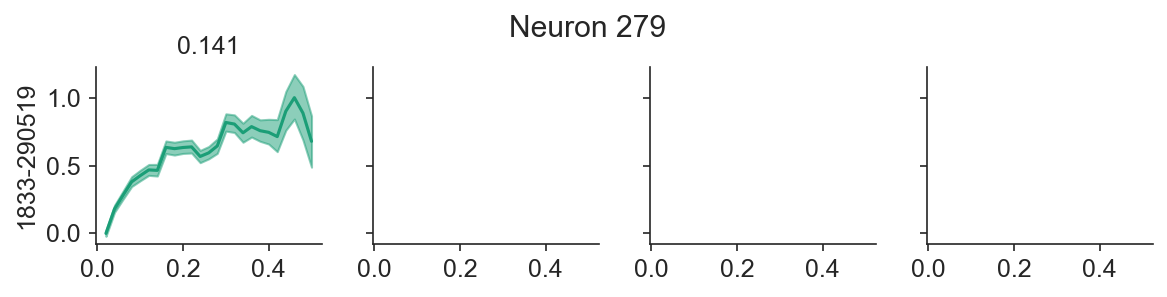

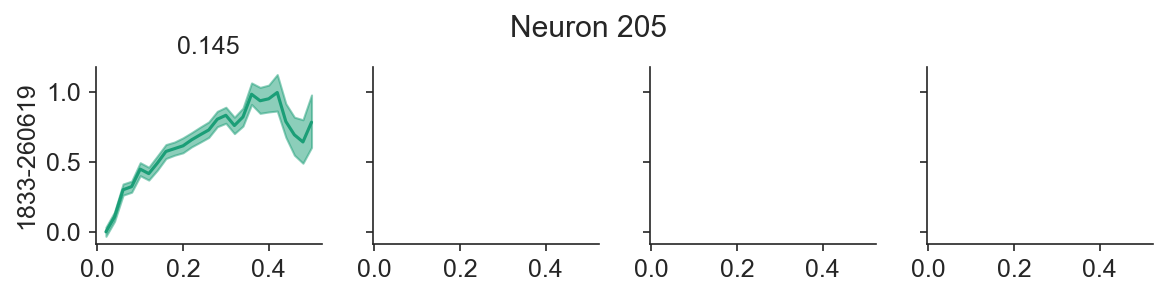

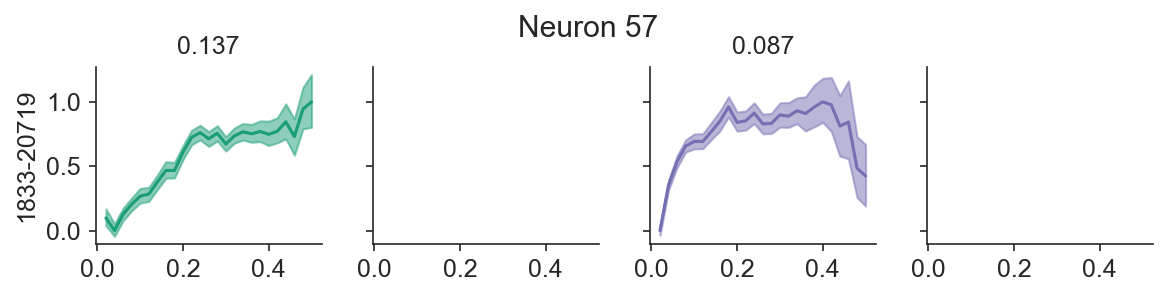

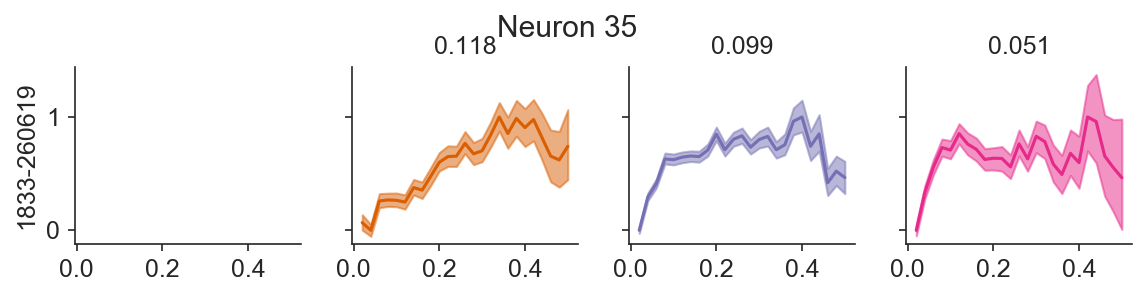

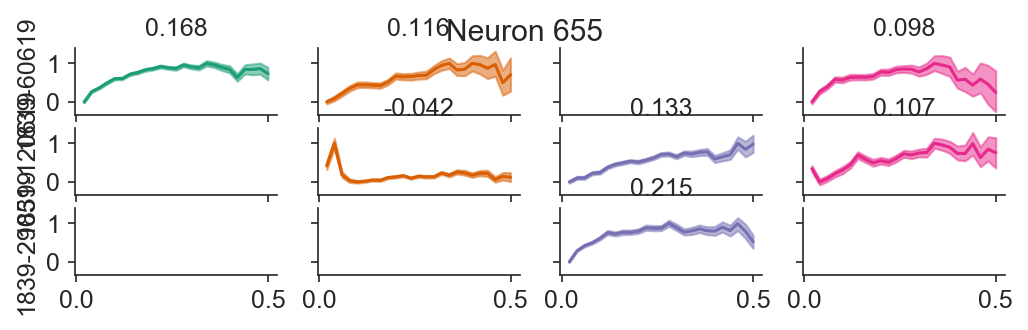

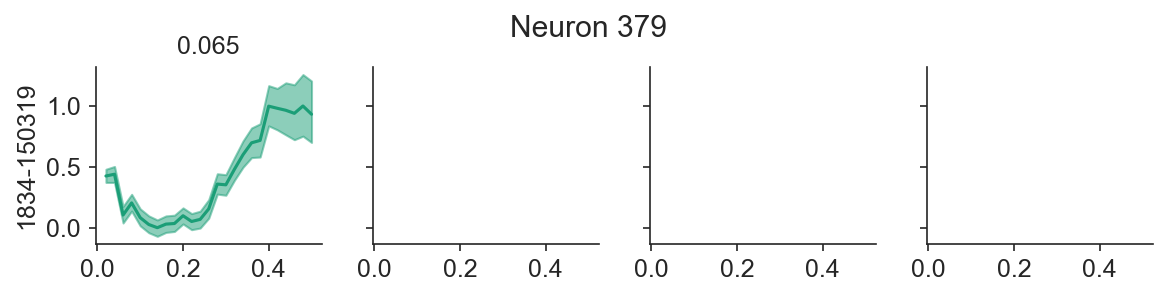

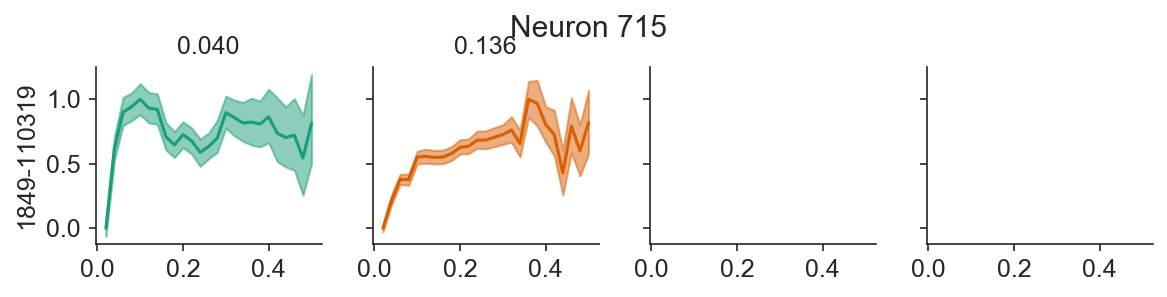

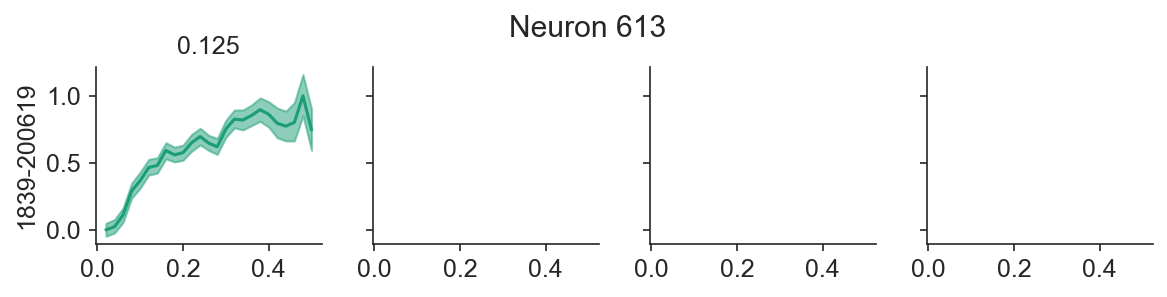

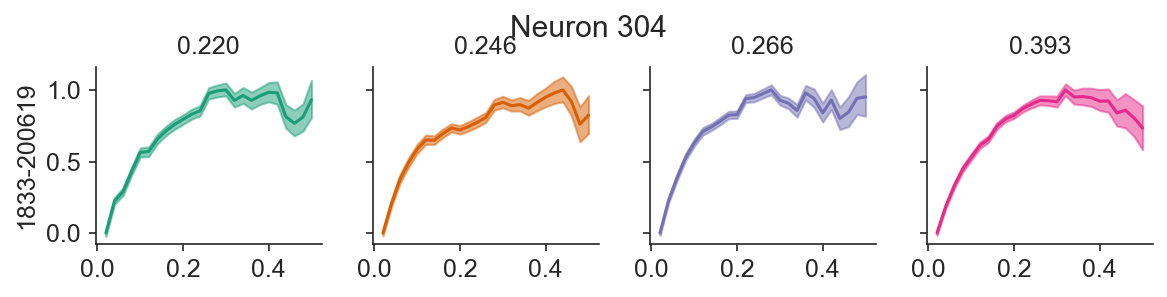

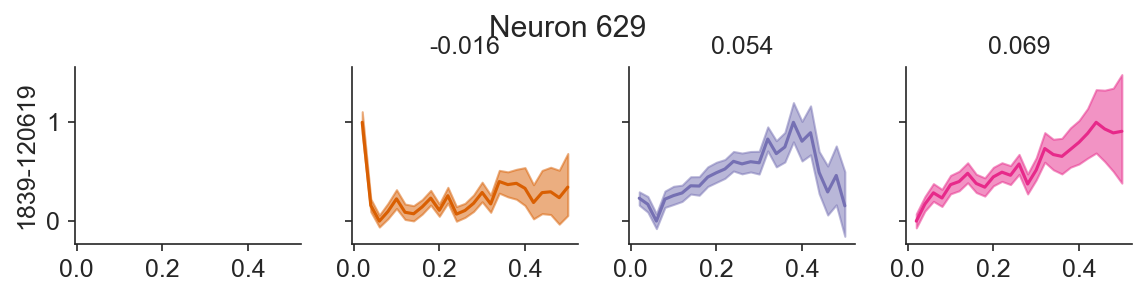

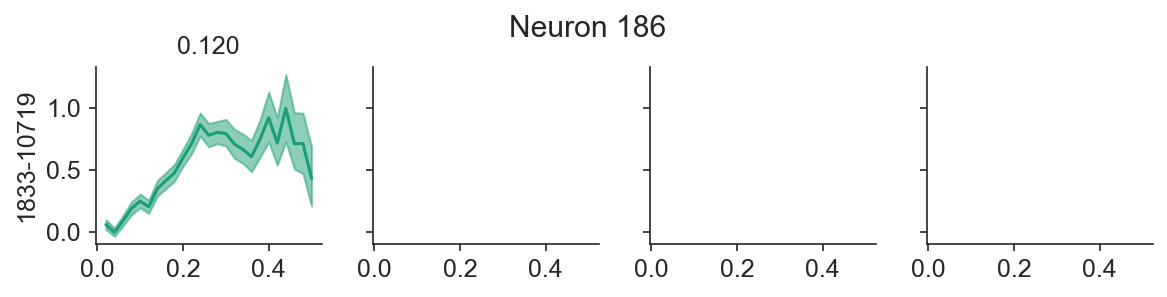

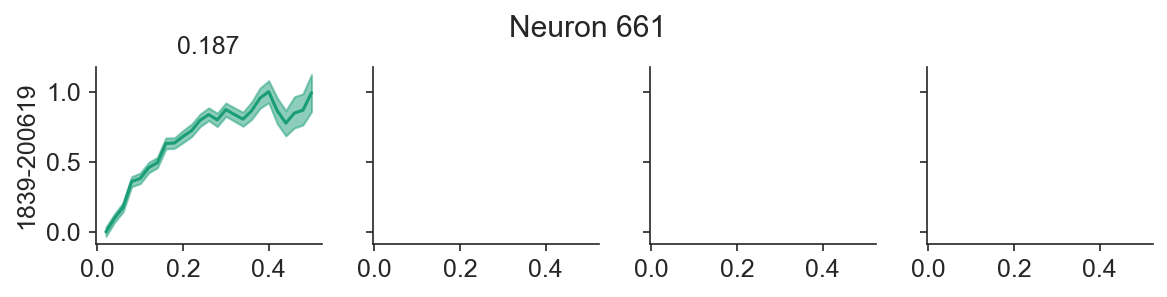

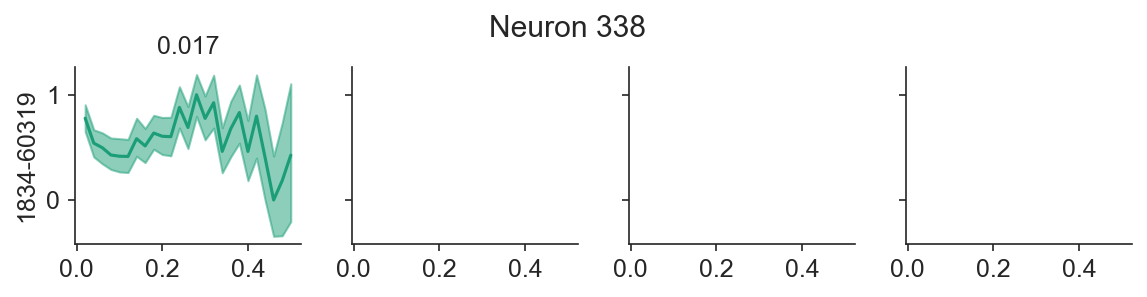

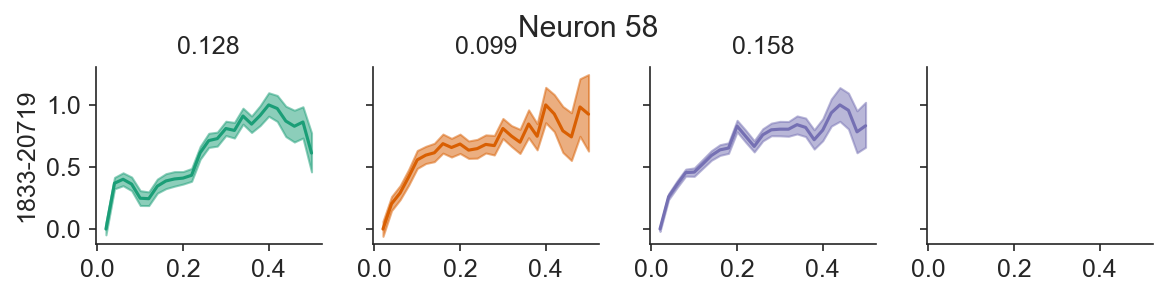

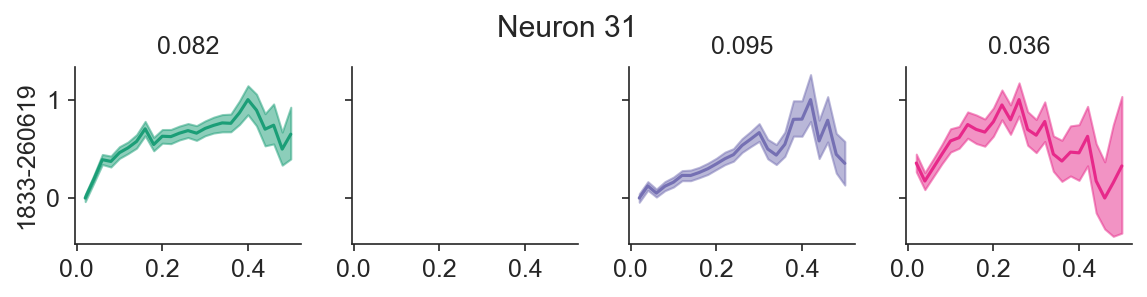

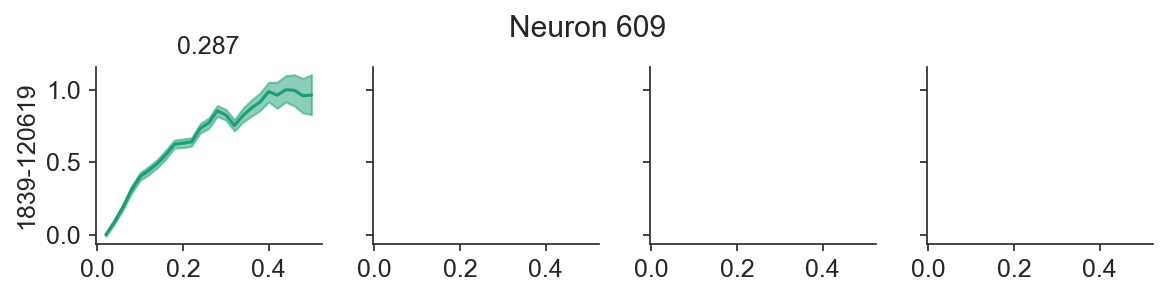

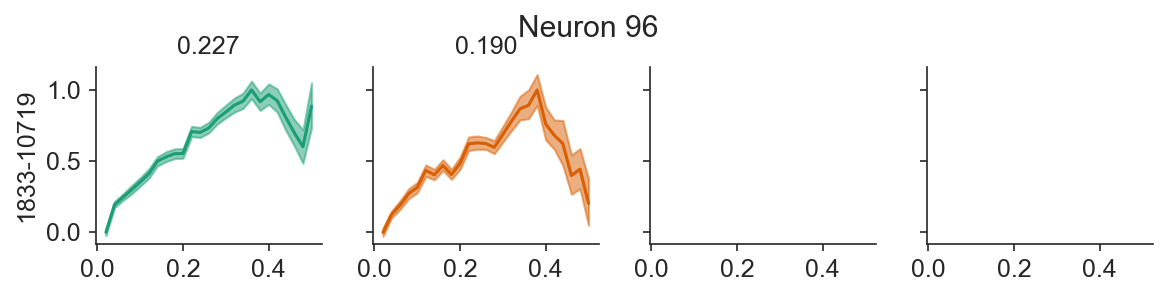

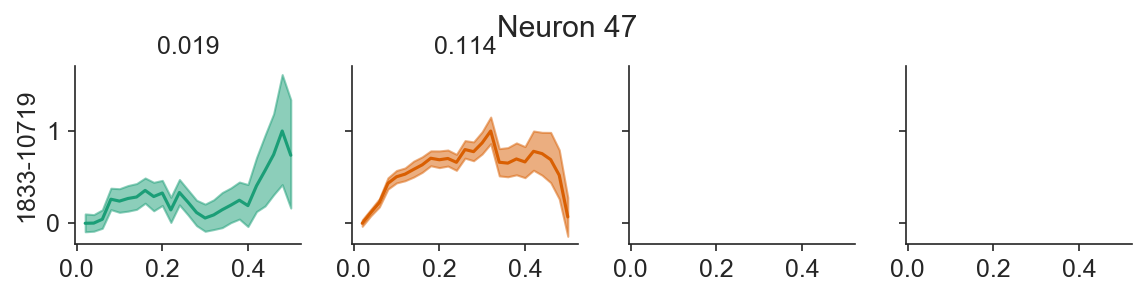

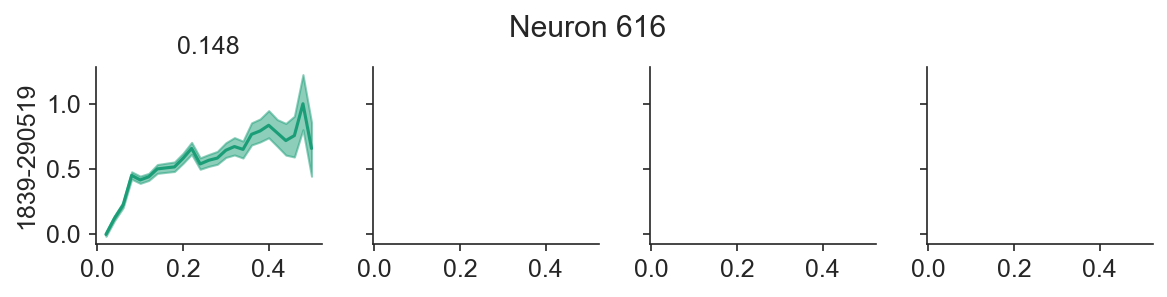

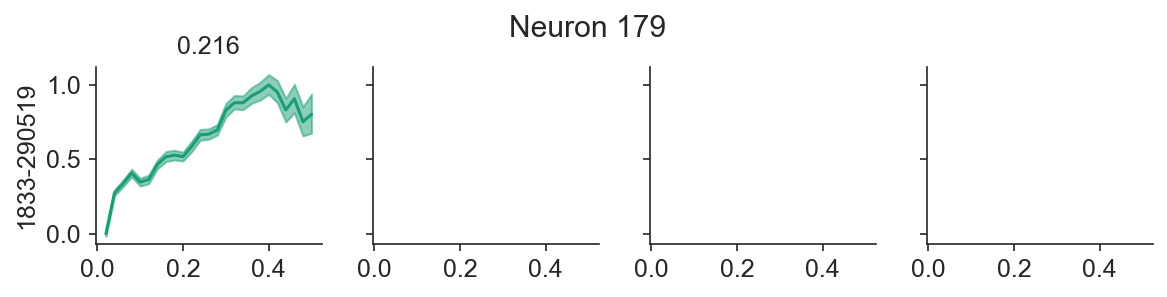

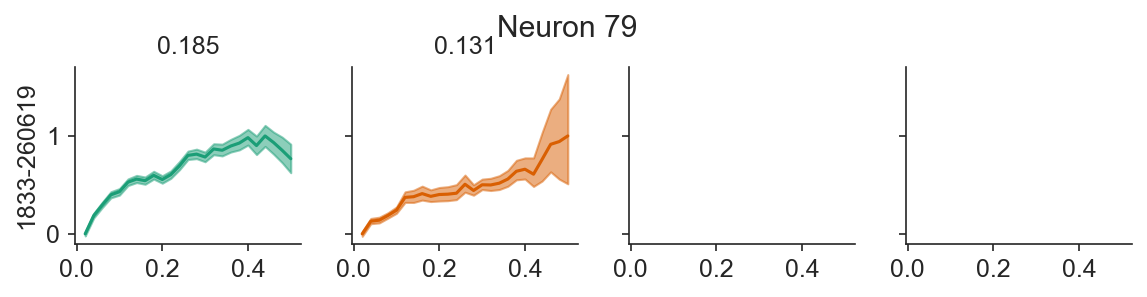

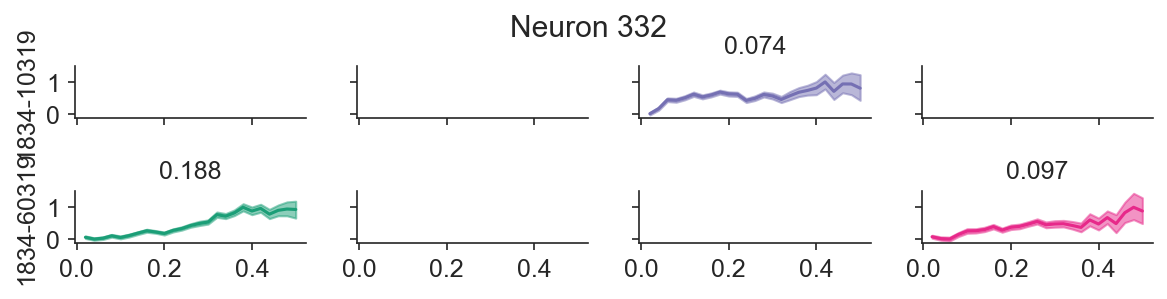

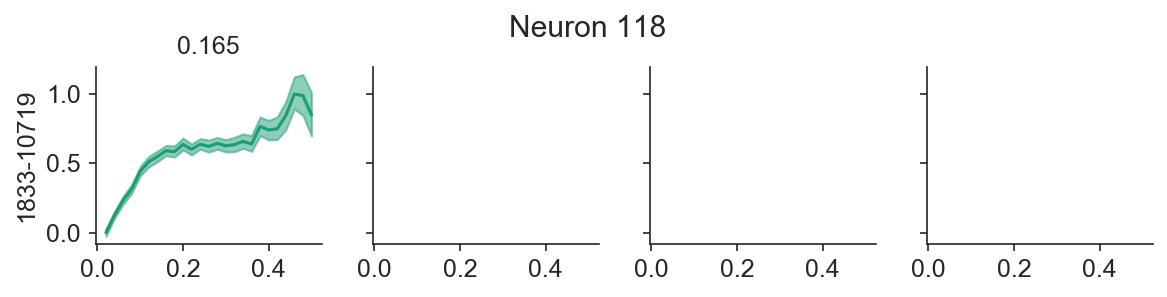

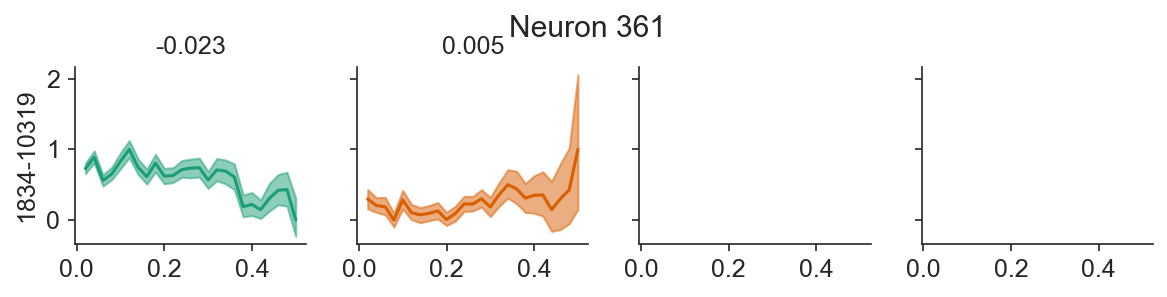

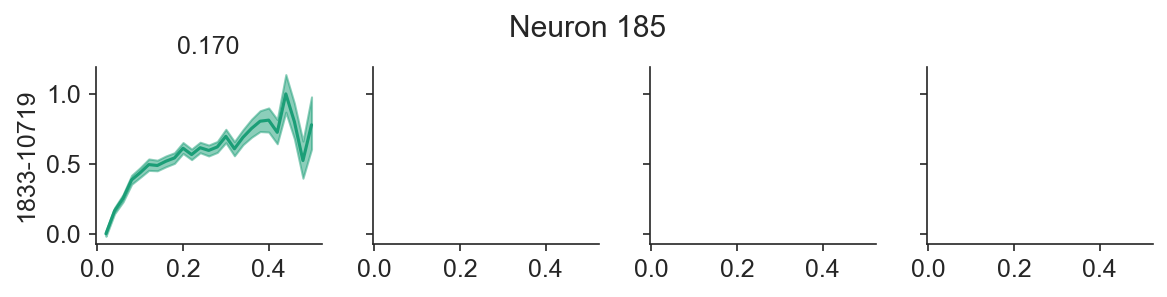

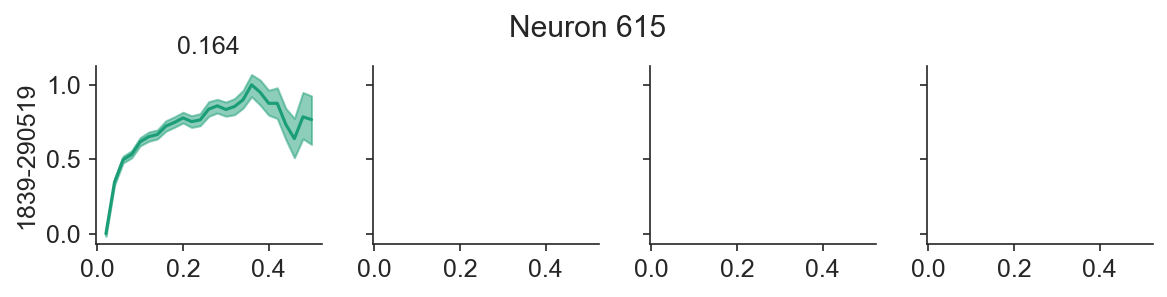

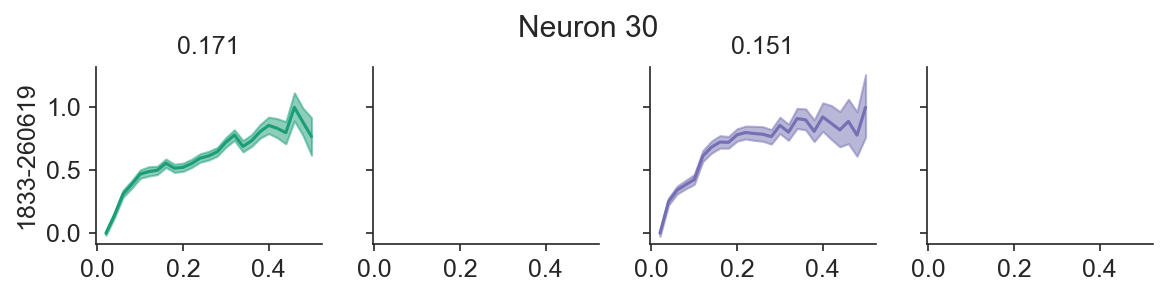

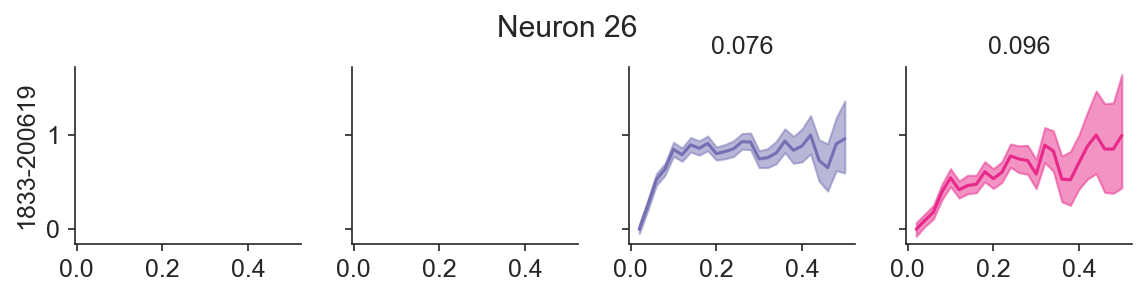

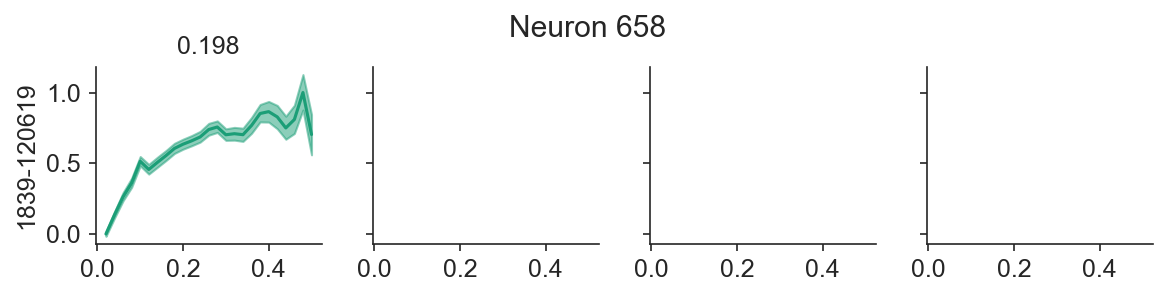

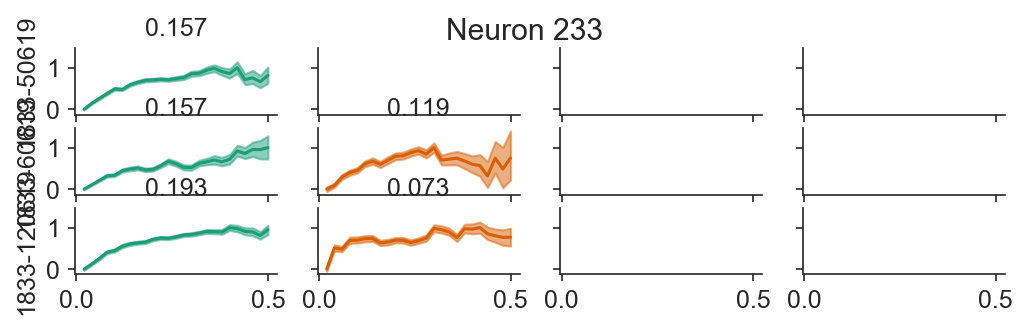

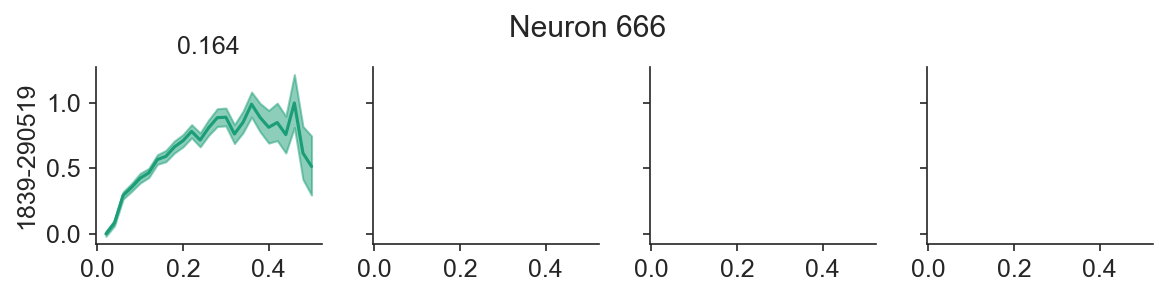

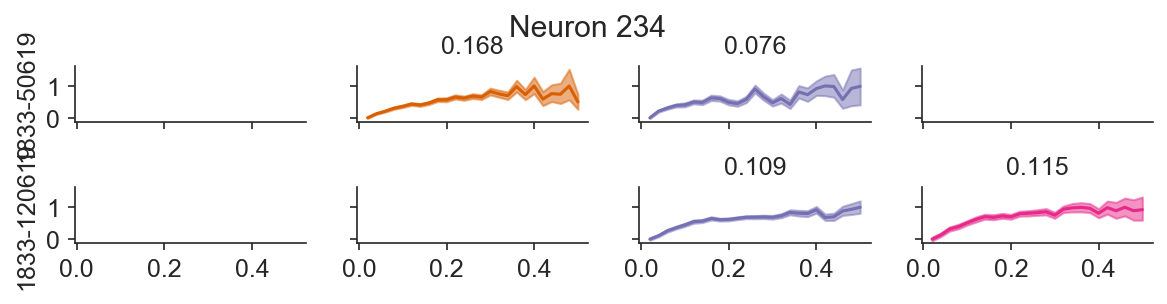

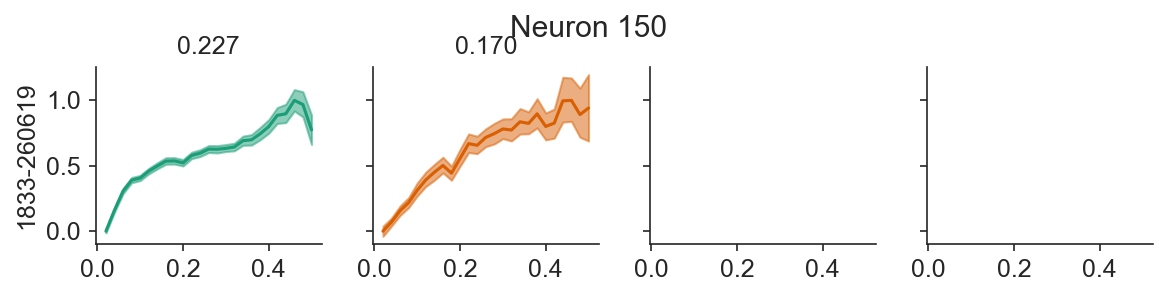

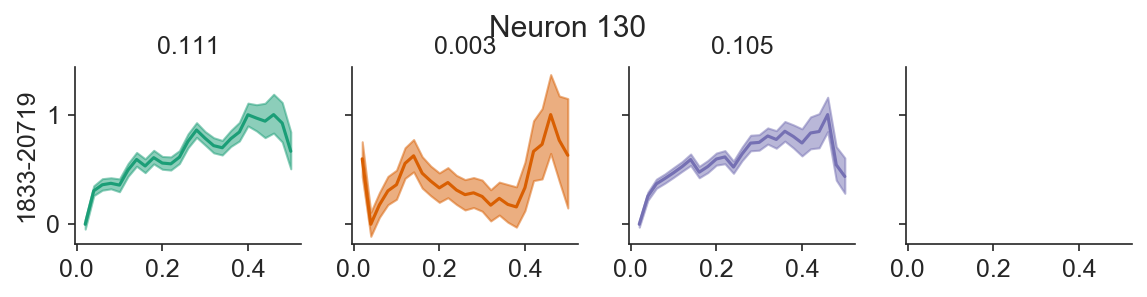

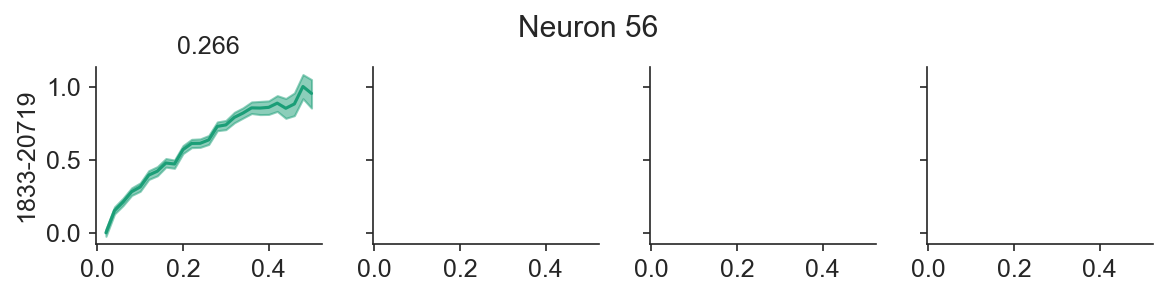

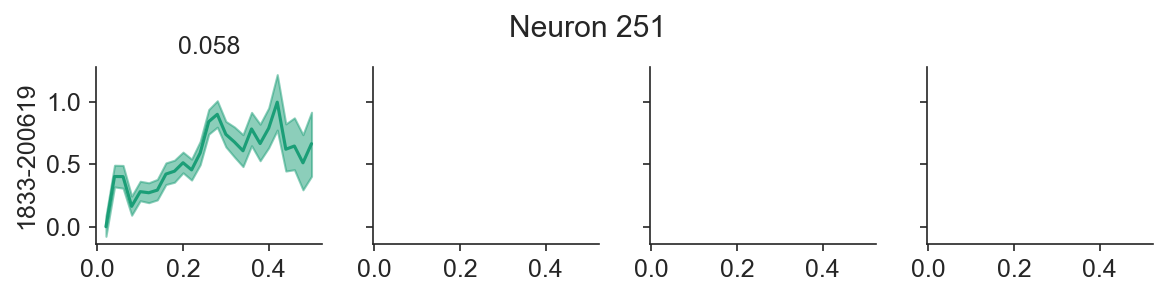

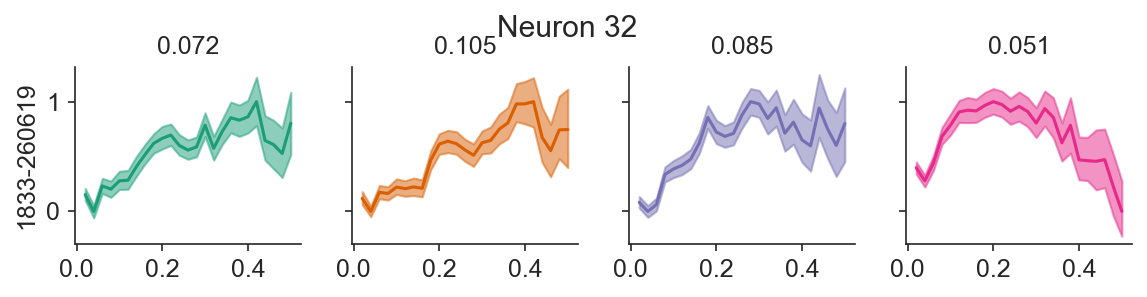

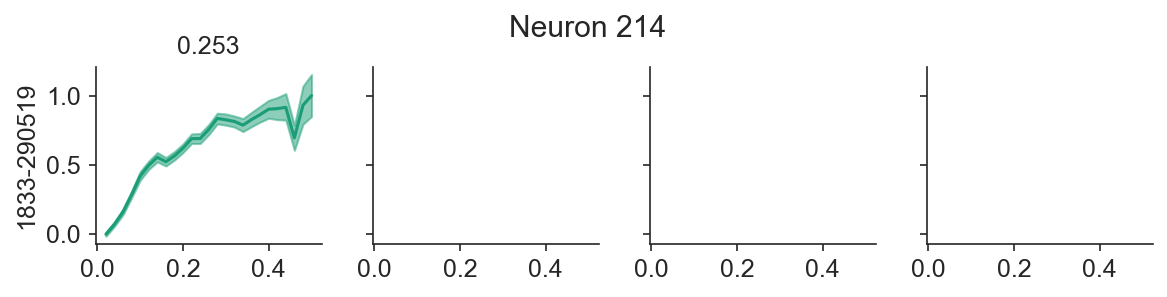

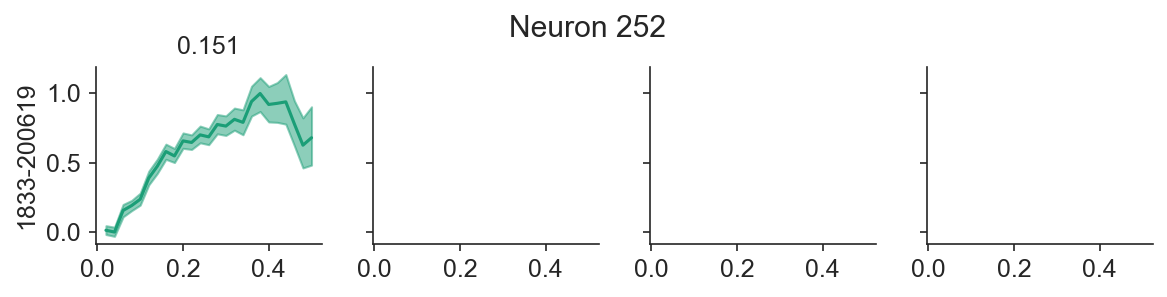

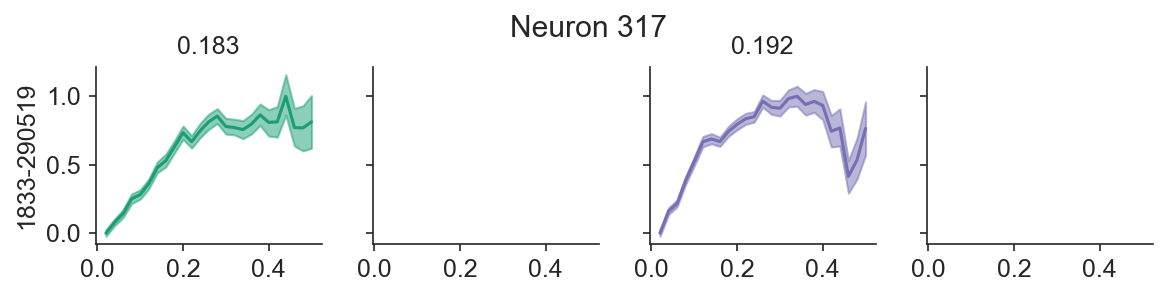

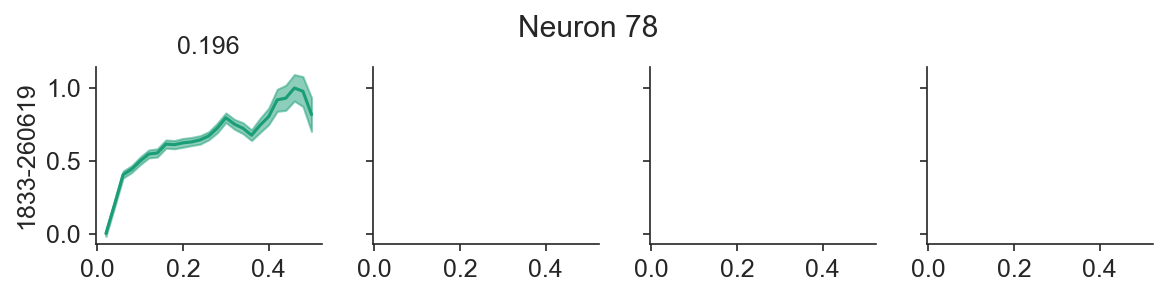

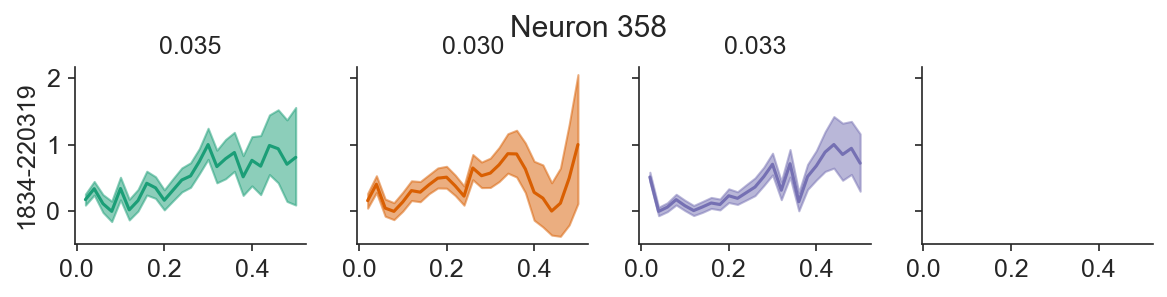

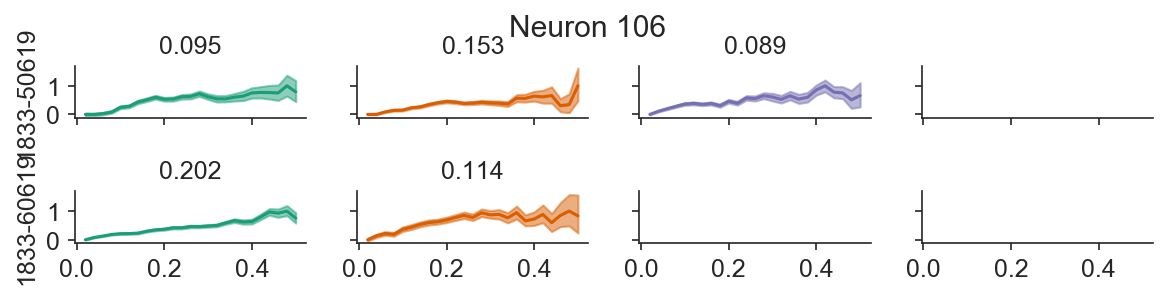

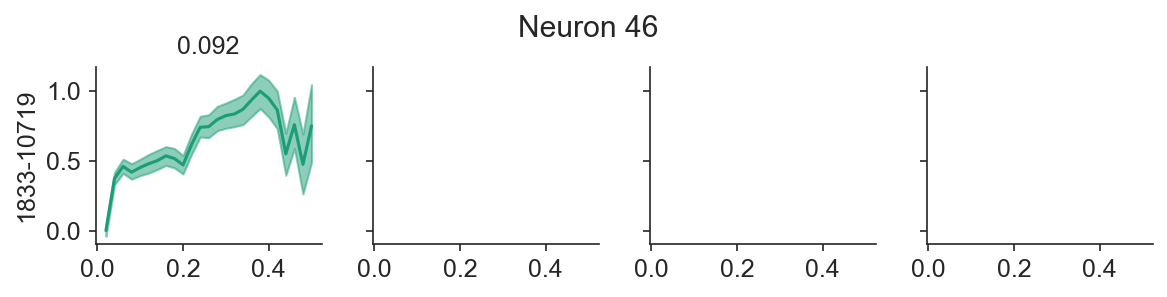

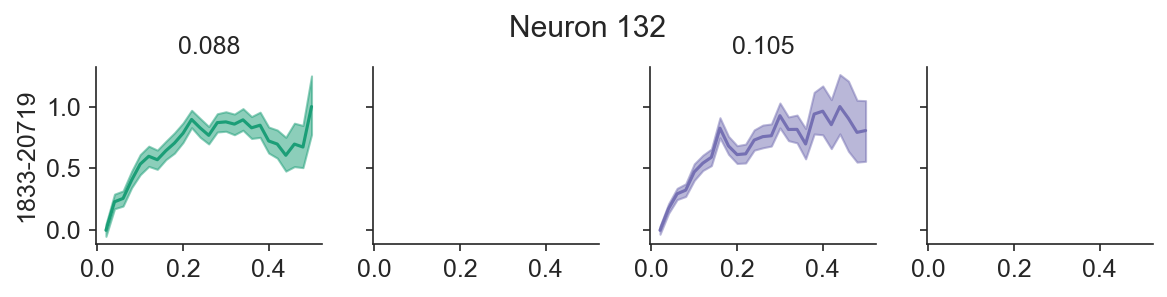

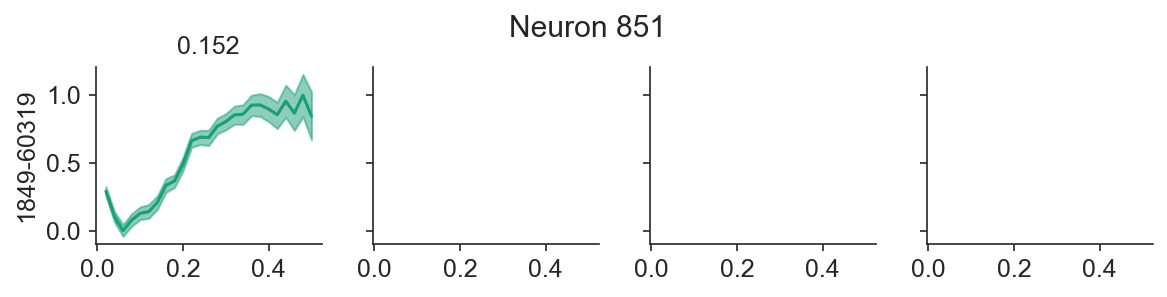

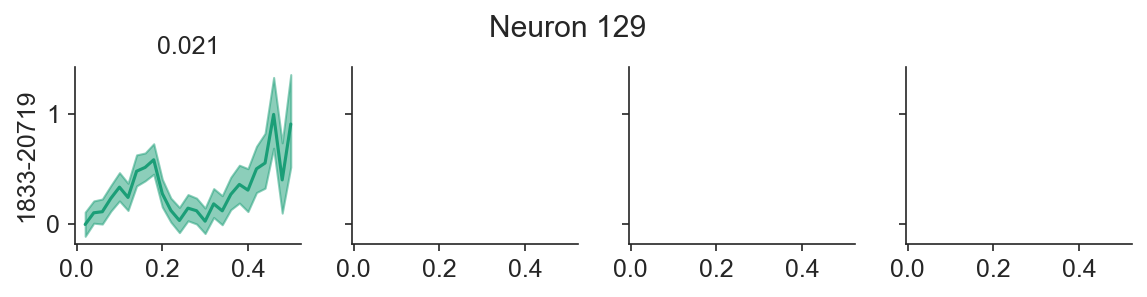

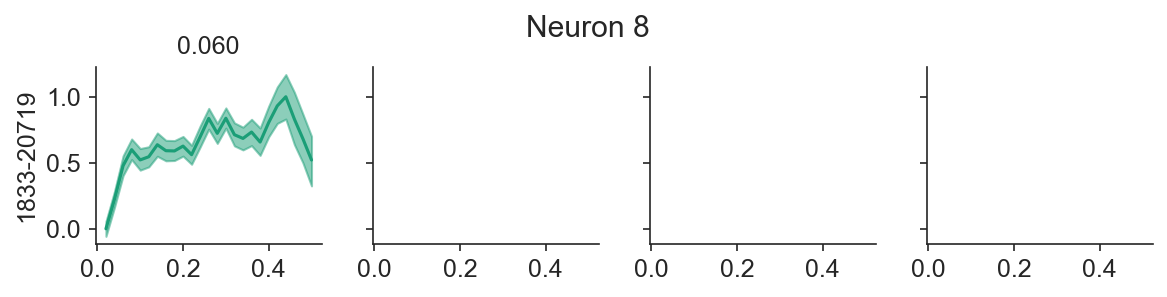

In [96]:
from septum_mec.analysis.plotting import plot_uncertainty

for unit_id, id_num in gridcell_id_map.items():
# id_num = 304
# if True:
    sessions = data.query(f'gridcell and unit_idnum=="{id_num}"')
    n_action = sessions.date.nunique()
    fig, axs = plt.subplots(n_action, 4, sharey=True, sharex=True)
    despine()
    fig.suptitle(f'Neuron {id_num}')
    if n_action == 1:
        axs = [axs]
    waxs = None
    for ax, (date, rows) in zip(axs, sessions.groupby('date')):
        entity = rows.iloc[0].entity
        ax[0].set_ylabel(f'{entity}-{date}')
        for _, row in rows.iterrows():
            idx = row.session_id
            
            speed, t, spike_times, mask = load_speed(
                    row['action'], row['channel_group'], row['unit_name'], 
                    z1, zg2, z3, split=False)

            speed_score, inst_speed, rate, times = spd.speed_correlation(
                speed, t, spike_times, return_data=True, mask=mask)
            
            inst_speed = inst_speed[~inst_speed.mask]
            rate = rate[~rate.mask]
            times = times[~times.mask]

            speed_bins = np.arange(min_speed, max_speed + speed_binsize, speed_binsize)
            ia = np.digitize(inst_speed, bins=speed_bins, right=True)
            rates = []

            for i in range(len(speed_bins)):
                rates.append(rate[ia==i])
            ax[idx].set_title(f'{speed_score:.3f}')
#             plot_uncertainty(speed_bins, rates, ax=ax[idx], normalize_values=True)
            plot_bootstrap_timeseries(speed_bins, rates, ax=ax[idx], normalize_values=True, color=colors[idx])
#             rr = [rr for r in rates for rr in r]
#             aspect = (np.nanmax(rr) - np.nanmin(rr)) / (max_speed - min_speed)
            for a in ax:
                a.set_aspect('auto')

    plt.tight_layout()
    fig.savefig(
        output_path / 'figures' / f'gridcell_neuron_{id_num}_speed_map.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'gridcell_neuron_{id_num}_speed_map.svg', 
        bbox_inches='tight', transparent=True)

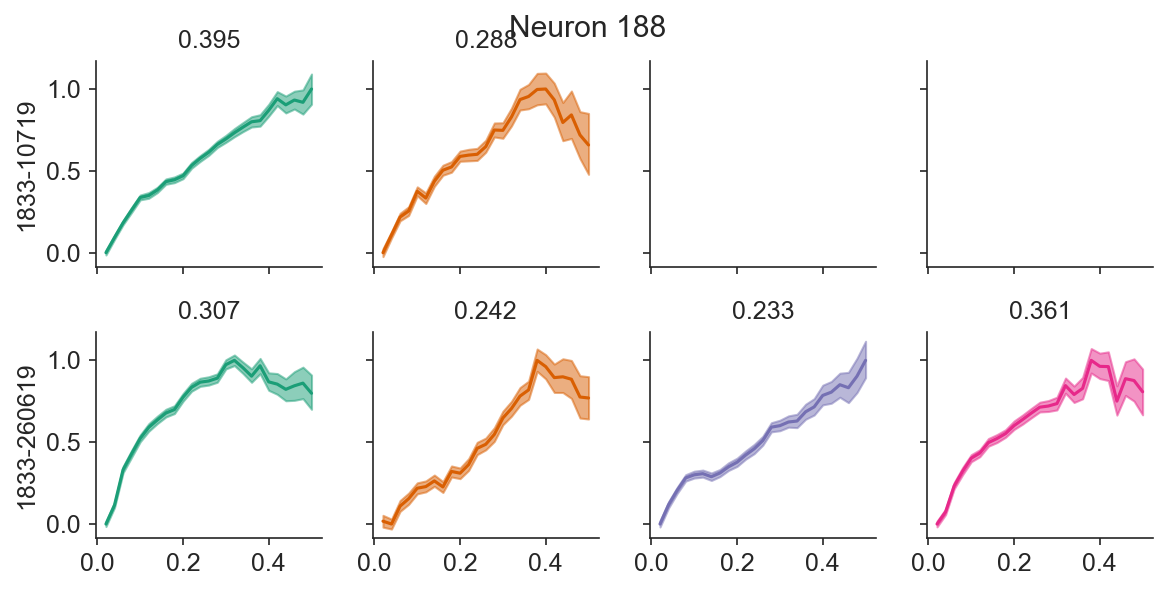

In [99]:

# for unit_id, id_num in nsi_id_map.items():
id_num = 188
if True:
    sessions = data.query(f'ns_inhibited and unit_idnum=="{id_num}"')
    n_action = sessions.date.nunique()
    fig, axs = plt.subplots(n_action, 4, sharey=True, sharex=True, figsize=(8, 2*n_action))
    despine()
    fig.suptitle(f'Neuron {id_num}')
    if n_action == 1:
        axs = [axs]
    waxs = None
    for ax, (date, rows) in zip(axs, sessions.groupby('date')):
        entity = rows.iloc[0].entity
        ax[0].set_ylabel(f'{entity}-{date}')
        for _, row in rows.iterrows():
            idx = row.session_id
            
            speed, t, spike_times, mask = load_speed(
                    row['action'], row['channel_group'], row['unit_name'], 
                    z1, zi2, z3, split=False)

            speed_score, inst_speed, rate, times = spd.speed_correlation(
                speed, t, spike_times, return_data=True, mask=mask)
            
            inst_speed = inst_speed[~inst_speed.mask]
            rate = rate[~rate.mask]
            times = times[~times.mask]

            speed_bins = np.arange(min_speed, max_speed + speed_binsize, speed_binsize)
            ia = np.digitize(inst_speed, bins=speed_bins, right=True)
            rates = []

            for i in range(len(speed_bins)):
                rates.append(rate[ia==i])

            ax[idx].set_title(f'{speed_score:.3f}')
            plot_bootstrap_timeseries(speed_bins, rates, ax=ax[idx], normalize_values=True, color=colors[idx])
#             rr = [rr for r in rates for rr in r]
#             aspect = (max_speed - min_speed) / (np.nanmax(rr) - np.nanmin(rr))
            for a in ax:
                a.set_aspect('auto')
    plt.tight_layout()
    fig.savefig(
        output_path / 'figures' / f'nsi_neuron_{id_num}_speed_map.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'nsi_neuron_{id_num}_speed_map.svg', 
        bbox_inches='tight', transparent=True)

In [26]:
import speed_cells.speed as spd
from septum_mec.analysis.plotting import plot_bootstrap_timeseries
speed_dist = [[], [], [], []]
speed_bins = np.arange(min_speed, 1 + speed_binsize, speed_binsize)
for unit_id, id_num in results_id_map.items():
    sessions = once_a_gridcell.query(f'unit_id=="{unit_id}"')

    for date, rows in sessions.groupby('date'):
        entity = rows.iloc[0].entity
        for _, row in rows.iterrows():
            action_id = row['action']
            channel_id = row['channel_group']
            unit_name = row['unit_name']
            idx = row.session_id
            x, y, t, speed = map(data_loader.tracking(action_id).get, ['x', 'y', 't', 'v'])
            hist, _ = np.histogram(speed, bins=speed_bins, density=True, )
            speed_dist[idx].append(hist)
            

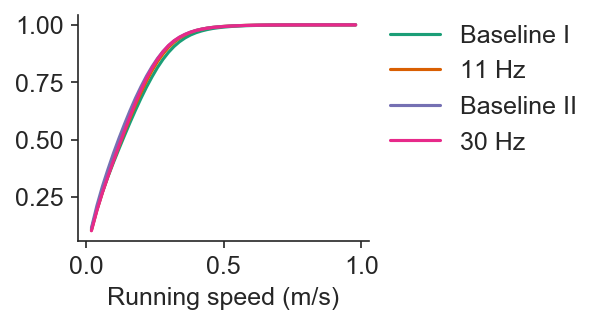

In [27]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (2.5, 2), 
    'figure.dpi': 150
})
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
fig = plt.figure()
for i in range(len(speed_dist)):
    plt.plot(
        speed_bins[:-1], np.cumsum(np.array(speed_dist[i]).mean(0))*speed_binsize, 
        c=colors[i], label=labels[i])
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
despine()
plt.xlabel('Running speed (m/s)')
fig.savefig(output_path / 'figures' / 'running_speed.png', bbox_inches='tight', transparent=True)
fig.savefig(output_path / 'figures' / 'running_speed.svg', bbox_inches='tight')

In [46]:
labels = [
    'Baseline I vs baseline I',
    'Baseline I vs baseline II', 
    'Baseline I vs stim I', 
    'Baseline II vs stim II', 
    'Baseline I vs stim II'
]


def swarm_violin(data, ax=None, clip=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ticks = [0,1,2,3,4]

    violins = ax.violinplot(
        data, ticks, showmedians=True, showextrema=False, points=1000, bw_method=.3)

    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        if category in violins:
            violins[category].set_color(['w', 'w'])
            violins[category].set_linewidth(2.0)
            violins[category].set_zorder(10000)

    for pc in violins['bodies']:
        pc.set_facecolor('gray')
#         pc.set_edgecolor(c)
        pc.set_alpha(0.4)

    sns.stripplot(data=data, size=4, ax=ax, color='k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    y = -np.inf
    if clip is None:
        for val in data[1:]:
            data_max = np.max([max(data[0]), max(val)])
            data_min = np.min([min(data[0]), min(val)])
            y_ = data_max * 1.05 + 0.025 * (data_max - data_min)
            if y_ > y:
                y = y_
    else:
        y = clip
        ax.set_ylim(0, clip)
        
    x = 1
    for val in data[1:]:
        Uvalue, pvalue = scipy.stats.mannwhitneyu(data[0], val, alternative='two-sided')
        # significance
        if pvalue < 0.0001:
            significance = "****"
        elif pvalue < 0.001:
            significance = "***"
        elif pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = "ns"

        ax.text(x, y, significance, ha='center', va='bottom')
        x += 1

In [47]:
pairwise_gridcell = [[], [], [], [], []]
for i, pairs in enumerate(gridcell_speed):
    for j, pair in enumerate(pairs):
        pairwise_gridcell[i].append(np.diff(pair))
        
pairwise_nsi = [[], [], [], [], []]
for i, pairs in enumerate(nsi_speed):
    for j, pair in enumerate(pairs):
        pairwise_nsi[i].append(np.diff(pair))

In [101]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (4, 3), 
    'figure.dpi': 150
})

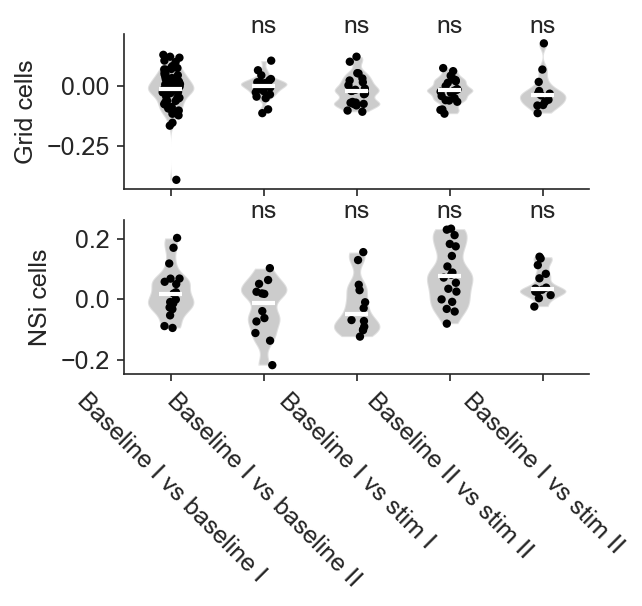

In [102]:
fig, axs = plt.subplots(2, 1, sharex=True)

swarm_violin(pairwise_gridcell, ax=axs[0])
axs[0].set_ylabel('Grid cells')

swarm_violin(pairwise_nsi, ax=axs[1])
axs[1].set_ylabel('NSi cells')

despine()
plt.xticks([0,1,2,3,4], labels, rotation=-45, ha='center')
# plt.tight_layout()
fig.savefig(output_path / 'figures' / 'violins_swarm.png', bbox_inches='tight')
fig.savefig(output_path / 'figures' / 'violins_swarm.svg', bbox_inches='tight')

# Save to expipe

In [76]:
action = project.require_action("longitudinal-comparisons-speed")

In [77]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-speed/data/figures/gridcell_neuron_106_speed_map.png',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-speed/data/figures/neuron_359_speed_map.svg',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-speed/data/figures/gridcell_neuron_205_speed_map.png',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-speed/data/figures/gridcell_neuron_78_speed_map.svg',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-speed/data/figures/gridcell_neuron_358_speed_map.png',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-speed/data/figures/gridcell_neuron_150_speed_map.png',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-speed/data/figures/gridcell_neuron_26_speed_map.png',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-speed/data/figures/gridcell_neuron_251_speed_map.png',
 '/media/storage/expipe/sep

In [78]:
septum_mec.analysis.registration.store_notebook(action, "20_longitudinal_comparisons_speed.ipynb")